<a href="https://colab.research.google.com/github/julien-medina-phd/Kaggle-Titanic/blob/master/Kaggle_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Titanic: Machine Learning from Disaster**

https://www.kaggle.com/c/titanic/overview

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import LinearSVC, SVC

In [0]:
np.random.seed(100)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
df_given = pd.read_csv("train.csv")
df_compet = pd.read_csv("test.csv")

# **Data exploration**

Data Dictionary

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	

Age	Age in years	

sibsp	# of siblings / spouses aboard the Titanic	

parch	# of parents / children aboard the Titanic	

ticket	Ticket number	

fare	Passenger fare	

cabin	Cabin number	

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [6]:
df_given.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_given.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# **Data preprocessing**

In [8]:
df_given.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are missing data "NaN" in the Age, Cabin and Embarked columns. We are going to replace missing Age values with the mean of all ages.

In [9]:
df_given.Age.mean()

29.69911764705882

In [0]:
df_given.Age.fillna(df_given.Age.mean(), inplace =True)

In [11]:
df_given.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# **Data understanding**

How many survived ?

In [12]:
df_given.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

On the 891 people in the training set, 342 survived.

Text(0.5, 1.0, 'How many people perished or survived?')

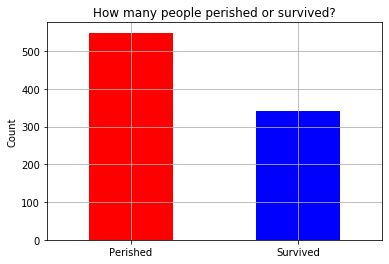

In [13]:
df_given.Survived.value_counts().plot(kind="bar",color=["r","b"])
plt.grid()
plt.xticks([0,1],("Perished","Survived"), rotation='horizontal')
plt.ylabel("Count")
plt.title("How many people perished or survived?")

What is the percentage of people who survived? (in the training data set)


In [14]:
print("Around {:.3}% of all the passengers (of the training set) survived.".format(df_given["Survived"].sum()/len(df_given["Survived"])*100))

Around 38.4% of all the passengers (of the training set) survived.


Text(0.5, 1.0, 'Females')

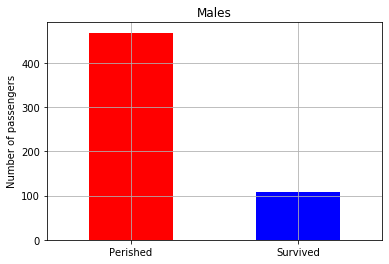

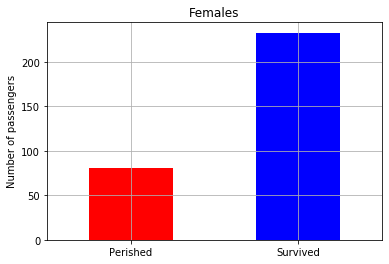

In [15]:
df_given[df_given.Sex == "male"].Survived.value_counts().plot(kind="bar",color=["r","b"])
plt.grid()
plt.xticks([0,1],("Perished","Survived"), rotation='horizontal')
plt.ylabel("Number of passengers")
plt.title("Males")
plt.figure()
df_given[df_given.Sex == "female"].Survived.value_counts(ascending=True).plot(kind="bar",color=["r","b"])
plt.grid()
plt.xticks([0,1],("Perished","Survived"), rotation='horizontal')
plt.ylabel("Number of passengers")
plt.title("Females")

The passengers sex appear to have a major influence on the survivability

We also have the intuition that the age of the passengers have a major influence on the survivability

(0, 55)

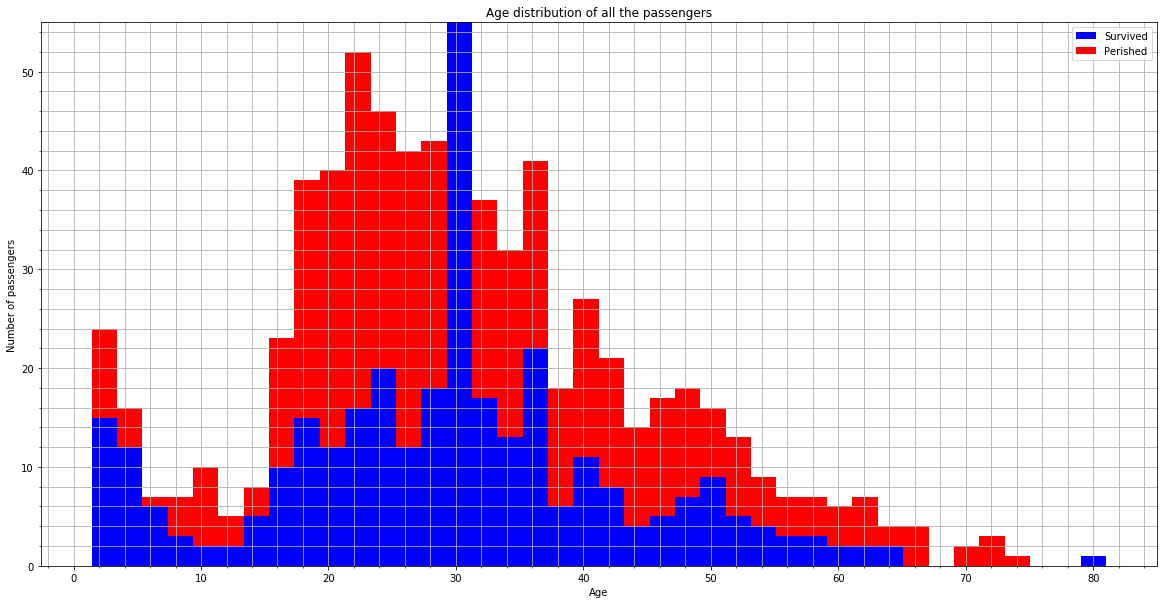

In [16]:
plt.figure(figsize=(20,10))
plt.hist([df_given[df_given.Survived==1]['Age'],df_given[df_given.Survived==0]['Age']], stacked = True, bins=40, color = ['b','r'], label = ['Survived','Perished'],align="right")
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.title("Age distribution of all the passengers")
plt.minorticks_on()
plt.grid(which="both")
plt.ylim([0,55])

The peak at 30 years old is due to filling the NaN values with the mean and is not relevant.

Text(0.5, 1.0, 'Percentage of people who survived, by age')

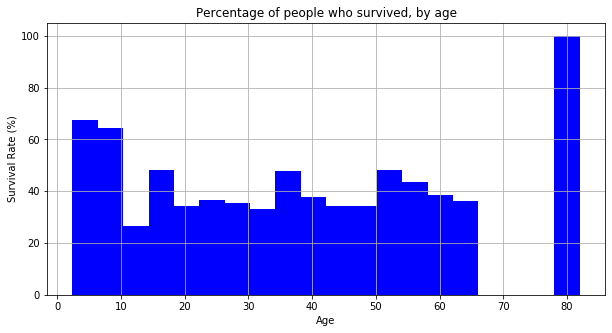

In [17]:
age_bins = np.linspace(df_given.Age.min(),df_given.Age.max(),21)
survived_hist = np.histogram(df_given[df_given['Survived']==1]['Age'],bins=age_bins,range=(0,80))
not_survive_hist = np.histogram(df_given[df_given['Survived']==0]['Age'],bins=age_bins,range=(0,80))
surv_rates = survived_hist[0]/(survived_hist[0]+not_survive_hist[0])

plt.figure(figsize=(10,5))
plt.bar(age_bins[1:], surv_rates*100, width=age_bins[1]-age_bins[0],color="b")
plt.xlabel('Age')
plt.ylabel('Survival Rate (%)')
plt.grid()
plt.title("Percentage of people who survived, by age")

In [18]:
df_given[df_given.Age>70].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


It appears that globally, children (under 10 years old) had the best survival rate. The peak at 80 years old is not statistically relevant because there is only one person 
at age 80.

We have another intuition that the ticket price (fare) influenced the survivability of the passenger. Let us check.

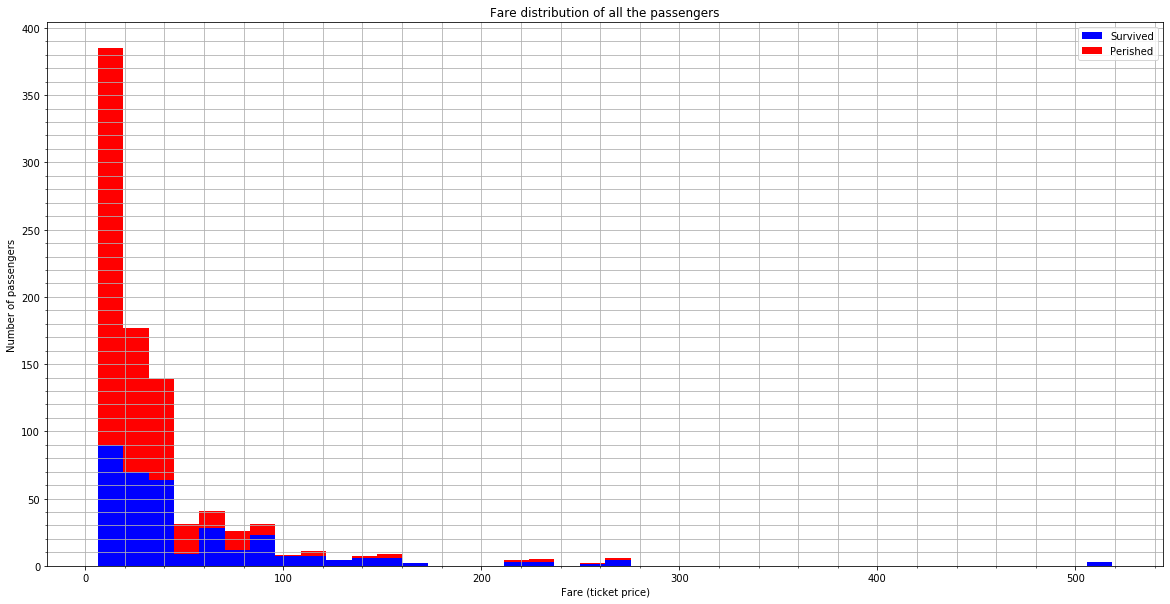

In [19]:
plt.figure(figsize=(20,10))
plt.hist([df_given[df_given.Survived==1]['Fare'],df_given[df_given.Survived==0]['Fare']], stacked = True, bins=40, color = ['b','r'], label = ['Survived','Perished'],align="right")
plt.xlabel('Fare (ticket price)')
plt.ylabel('Number of passengers')
plt.legend()
plt.title("Fare distribution of all the passengers")
plt.minorticks_on()
plt.grid(which="both")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Percentage of people who survived, by fare (ticket price)')

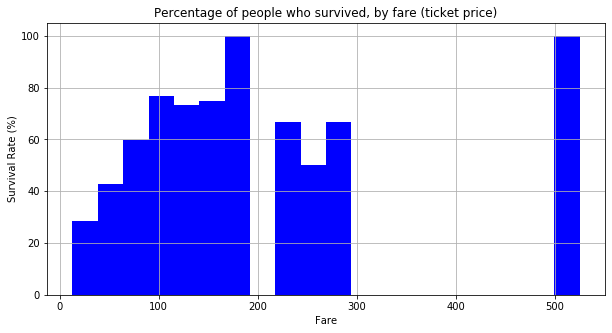

In [20]:
fare_bins = np.linspace(df_given.Fare.min(),df_given.Fare.max(),21)
survived_hist = np.histogram(df_given[df_given['Survived']==1]['Fare'],bins=fare_bins,range=(0,515))
not_survive_hist = np.histogram(df_given[df_given['Survived']==0]['Fare'],bins=fare_bins,range=(0,515))
surv_rates = survived_hist[0]/(survived_hist[0]+not_survive_hist[0])

plt.figure(figsize=(10,5))
plt.bar(fare_bins[1:], surv_rates*100, width=fare_bins[1]-fare_bins[0],color="b")
plt.xlabel('Fare')
plt.ylabel('Survival Rate (%)')
plt.grid()
plt.title("Percentage of people who survived, by fare (ticket price)")

The people with less than 50% chance of survival were the people who paid less than ~60 for their ticket.

Let us do the same analysis but with the passenger class instead of the fare.

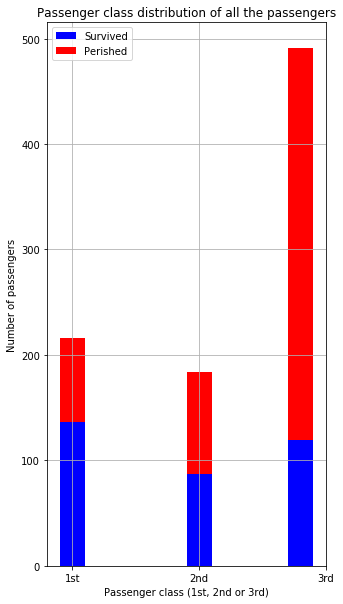

In [21]:
plt.figure(figsize=(5,10))
plt.hist([df_given[df_given.Survived==1]['Pclass'],df_given[df_given.Survived==0]['Pclass']], stacked = True, color = ['b','r'], label = ['Survived','Perished'],align="left")
plt.xlabel('Passenger class (1st, 2nd or 3rd)')
plt.ylabel('Number of passengers')
plt.xticks(np.array([1,2,3]),["1st","2nd","3rd"])
plt.legend()
plt.title("Passenger class distribution of all the passengers")
plt.grid(which="both")

The highest survival rate was in the first class, then the second and in last, the third class.

It seems that the columns "PassengerId", "Name" and "Ticket" are not relevant to the Survival column so we drop them.

In [0]:
df_given.drop(["PassengerId","Name","Ticket","Cabin"], axis =1, inplace = True)

In [23]:
df_given.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


# Machine Learning from the data

pop: Return item and drop from frame. Raise KeyError if not found.

In [0]:
y = df_given.pop('Survived')

In [25]:
df_given.head(100)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,3,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
95,3,male,29.699118,0,0,8.0500,S
96,1,male,71.000000,0,0,34.6542,C
97,1,male,23.000000,0,1,63.3583,C
98,2,female,34.000000,0,1,23.0000,S


In [0]:
X_given = pd.get_dummies(df_given)

In [27]:
X_given.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


We should delete one of the Sex columns and one of the Embarked column to avoid redundancy.

In [0]:
X_given.drop(["Sex_male","Embarked_S"], axis =1, inplace = True)

In [29]:
X_given.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,3,22.0,1,0,7.2500,0,0,0
1,1,38.0,1,0,71.2833,1,1,0
2,3,26.0,0,0,7.9250,1,0,0
3,1,35.0,1,0,53.1000,1,0,0
4,3,35.0,0,0,8.0500,0,0,0


# LinearSVC

In [0]:
steps = [("scaler", StandardScaler()), ("lsvc", LinearSVC(random_state=42))]

In [0]:
pipeline = Pipeline(steps)

In [0]:
# Specify the hyperparameter space
parameters = {'lsvc__max_iter':np.arange(1000,100000)}

In [0]:
# Create the GridSearchCV object: gcv
rgs = RandomizedSearchCV(pipeline,parameters)

In [79]:
rgs.fit(X_given,y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('lsvc',
                                              LinearSVC(C=1.0,
                                                        class_weight=None,
                                                        dual=True,
                                                        fit_intercept=True,
                                                        intercept_scaling=1,
                                                        loss='squared_hinge',
                                                        max_iter=1000,
                                                        mult

# KNN

In [0]:
steps = [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'knn__n_neighbors':np.arange(1,100),"knn__leaf_size":np.arange(1,100)}

In [0]:
# Create the GridSearchCV object: gcv
rgs = RandomizedSearchCV(pipeline,parameters)

In [97]:
rgs.fit(X_given,y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('knn',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                                   n_neighbors=5,
                                                                  

In [98]:
rgs.score(X_given,y)

0.819304152637486

In [99]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rgs.best_params_)) 
print("Best score is {}".format(rgs.best_score_))

Tuned Logistic Regression Parameters: {'knn__n_neighbors': 28, 'knn__leaf_size': 4}
Best score is 0.8103195028560668


# SVC

In [0]:
steps = [("scaler", StandardScaler()), ("knn", SVC())]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
#parameters = {'knn__n_neighbors':np.arange(1,100),"knn__leaf_size":np.arange(1,100)}

In [106]:
pipeline.fit(X_given,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [110]:
pipeline.score(X_given,y)

0.8462401795735129

# Random Forest

In [0]:
steps = [("scaler", StandardScaler()), ("rfc", RandomForestClassifier(n_jobs=-1))]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfc__n_estimators':np.arange(1,1000)}

In [0]:
# Create the GridSearchCV object: gcv
rgs = RandomizedSearchCV(pipeline,parameters)

In [133]:
rgs.fit(X_given,y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('rfc',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                 

In [126]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rgs.best_params_)) 
print("Best score is {}".format(rgs.best_score_))

Tuned Logistic Regression Parameters: {'rfc__n_estimators': 383}
Best score is 0.8148515472977215


# RandomForestRegressor

In [61]:
model = RandomForestRegressor(100, oob_score =True, n_jobs=1, random_state=42)
model.fit(X_given,y)
print  ("AUC score:", roc_auc_score(y,model.oob_prediction_))

AUC score: 0.8552711469018629


Now let us compare the importance of each feature, to the model.

In [62]:
importance = pd.Series(model.feature_importances_, index=X_given.columns)
importance.sort_values(ascending=False)

Sex_female    0.304092
Age           0.250505
Fare          0.241808
Pclass        0.103179
SibSp         0.048967
Parch         0.025526
Embarked_C    0.014970
Embarked_Q    0.010953
dtype: float64

Text(0.5, 1.0, 'Features ordered by importance to the model')

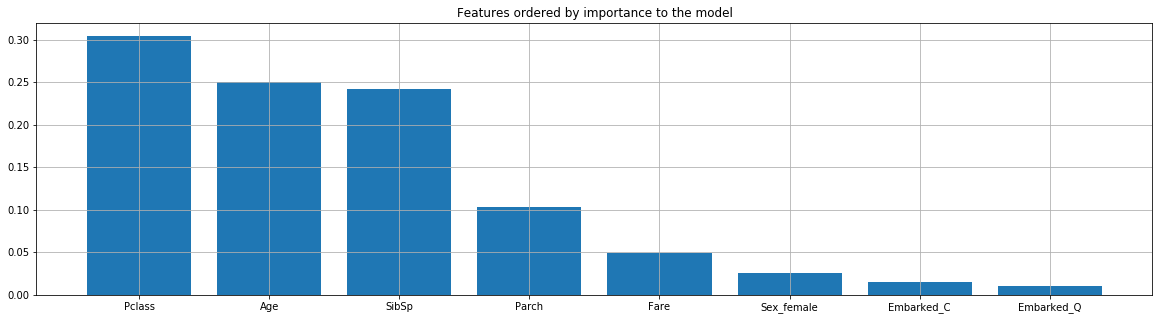

In [32]:
plt.figure(figsize=(20,5))
plt.bar(X_given.columns,importance.sort_values(ascending=False))
plt.grid()
plt.title("Features ordered by importance to the model")

In [0]:
forest = RandomForestRegressor(oob_score =True, n_jobs=1, random_state=42)

In [34]:
forest.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)>

In [0]:
# Specify the hyperparameter space
parameters = {"n_estimators":np.arange(1000,1001)}

In [0]:
gs_model = RandomizedSearchCV(forest,parameters)

In [40]:
gs_model.fit(X_given,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=1,
                 

In [41]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(gs_model.best_params_)) 
print("Best score is {}".format(gs_model.best_score_))

Tuned Logistic Regression Parameters: {'n_estimators': 1000}
Best score is 0.38194935658951923


In [42]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(gs_model,X_given,y,cv=5)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive se

[0.23992544 0.36981944 0.50423796 0.32009172 0.47567221]
Average 5-Fold CV Score: 0.38194935658951923


# Model on the test data

## Preprocessing test data

In [48]:
df_compet.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
df_compet.drop(["PassengerId","Name","Ticket","Cabin"], axis =1, inplace = True)

In [50]:
df_compet.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [0]:
X_compet = pd.get_dummies(df_compet)

In [52]:
X_compet.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1


In [0]:
X_compet.drop(["Sex_male","Embarked_S"], axis =1, inplace = True)

In [54]:
X_compet.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,3,34.5,0,0,7.8292,0,0,1
1,3,47.0,1,0,7.0000,1,0,0
2,2,62.0,0,0,9.6875,0,0,1
3,3,27.0,0,0,8.6625,0,0,0
4,3,22.0,1,1,12.2875,1,0,0


In [55]:
X_compet.isna().sum()

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_female     0
Embarked_C     0
Embarked_Q     0
dtype: int64

In [0]:
X_compet.Age.fillna(X_compet.Age.mean(), inplace =True)

In [0]:
X_compet.Fare.fillna(X_compet.Fare.mean(), inplace =True)

In [58]:
X_compet.isna().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Embarked_C    0
Embarked_Q    0
dtype: int64

In [87]:
X_compet.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,3,34.5,0,0,7.8292,0,0,1
1,3,47.0,1,0,7.0000,1,0,0
2,2,62.0,0,0,9.6875,0,0,1
3,3,27.0,0,0,8.6625,0,0,0
4,3,22.0,1,1,12.2875,1,0,0


## Model on test data

In [0]:
y_compet_pred = rgs.predict(X_compet)

In [0]:
df_compet = pd.read_csv("test.csv")

In [124]:
output = pd.DataFrame({'PassengerId': df_compet.PassengerId, 'Survived': y_compet_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [125]:
y_compet_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,